# Running Your First Models

In this notebook, we demonstrate the basic use of UCLCHEM's python module by running a simple model and then using the analysis functions to examine the output. Otherwise, it is identical to notebook 3.

In [1]:
import uclchem
import os

## A Simple Cloud

UCLCHEM's `Cloud` class, models a spherical cloud of isothermal gas. We can keep a constant density or have it increase over time following a freefall equation. This model is generally useful whenever you want to model a homogeneous cloud of gas under constant conditions. For example, in the inner parts of a molecular cloud where Av $\gtrsim$ 10 there are very few depth dependent processes. You may wish to model the whole of this UV shielded portion of the cloud with a single `Cloud` model.

Due to the large number of parameters in a chemical model and the way fortran and python interaction, we find it is easiest to do parameter input through python dictionaries. In this block, we define param_dict which contains the parameters we wish to modify for this run. Every `uclchem.model` class accepts a dictionary as an optional argument. Every parameter has a default value which is overridden if that parameter is specified in this dictionary. You can find a complete list of modifiable parameters and their default values in [our parameter docs](/docs/parameters).


In [2]:
# set a parameter dictionary for phase 1 collapse model
out_species = ["SO", "CO"]
param_dict = {
    "endAtFinalDensity": False,  # stop at finalTime
    "freefall": False,  # don't increase density in freefall
    "initialDens": 1e4,  # starting density
    "initialTemp": 10.0,  # temperature of gas
    "finalTime": 1.0e6,  # final time
    "rout": 0.1,  # radius of cloud in pc
    "baseAv": 1.0,  # visual extinction at cloud edge.
}
cloud = uclchem.model.Cloud(param_dict=param_dict, out_species=out_species)
cloud.check_error()

0

## Checking the output

The code above produced the object `cloud` which holds the variables associated to the model that UCLCHEM calculated. Calling `cloud.success_flag` would exposes the variable `success_flag` which will be 0 if the model was run successfully, and negative if not. You can check an error value by calling cloud.check_error() to get a more detailed error message.

Additionally, the `cloud` object holds the physical parameters and chemical abundance arrays calculated by UCLCHEM. These are stored in `cloud.physics_array` and `cloud.chemical_abun_array` respectively. If we wish to see just the abundances of the final time step, we can get that array with `cloud.next_starting_chemistry`, bearing in mind that the variable `cloud.starting_chemistry` contains the array of abundances that the model started with, if it was provided to the object.

If `abundSaveFile` was added to the `param_dict`, then the final abundances of all species would be written to the file  listed in `abundSaveFile`. If `outputFile` is added, then all abundances and physical parameters for all time steps will be written to the file `outputFile`.

The UCLCHEM model classes have methods to reformat the output arrays into pandas dataframes, as well as having the option to read previously run model output files. To retrieve a pandas dataframe of a model we can call `cloud.get_dataframes(point = 0)` where the point optional input allows us to choose which point we wish to retrieve the dataframe for, if we ran a multipoint model. This method defaults the `point` value to 0 to retrieve the central point.


In [3]:
cloud.get_dataframes().head()

,Time,Density,gasTemp,dustTemp,Av,radfield,zeta,point,H,H+,...,@OCS,@C4N,@SIC3,@SO2,@S2,@HS2,@H2S2,E-,BULK,SURFACE
0,0.000000e+00,10000.0,10.0,10.0,2.9287,1.0,1.0,1,0.5,1.000000e-30,...,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,0.000182,1.000000e-30,1.000000e-30
1,1.000000e-07,10000.0,10.0,10.0,2.9287,1.0,1.0,1,0.5,9.674390e-18,...,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,0.000182,5.613430e-20,7.478490e-13
2,1.000000e-06,10000.0,10.0,10.0,2.9287,1.0,1.0,1,0.5,9.674820e-17,...,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,1.000000e-30,0.000182,5.546840e-18,7.434010e-12
3,1.000000e-05,10000.0,10.0,10.0,2.9287,1.0,1.0,1,0.5,9.679150e-16,...,1.000010e-30,1.000010e-30,1.000010e-30,1.000010e-30,1.000010e-30,1.000010e-30,1.000010e-30,0.000182,5.538880e-16,7.428630e-11
4,1.000000e-04,10000.0,10.0,10.0,2.9287,1.0,1.0,1,0.5,9.722060e-15,...,1.000150e-30,1.000150e-30,1.000150e-30,1.000150e-30,1.000150e-30,1.000150e-30,1.000150e-30,0.000182,5.418340e-14,7.347030e-10


We can also test whether the model run went well by checking for element conservation. We do this because integrator errors often show up as a failure to conserve elemental abundances.

We can use `cloud.check_conservation(element_list=["H", "N", "C", "O", "S"])` to test whether we conserve elements in this run. This method prints the conservation results of elements listed in the argument `element_list` as a percentage of the original abundance by default. In an ideal case, these values are 0\% indicating the total abundance at the end of the model is exactly the same as the total at the start.

Changes of less than 1\% are fine for many cases but if they are too high, you could consider changing the `reltol` and `abstol` parameters that control the integrator accuracy. They are error tolerance, so smaller values lead to smaller errors and (usually) longer integration times. The default values were chosen by running a large grid of models and choosing the tolerances with the lowest average run time from those that conserved elements well and rarely failed. Despite this, there are no one-size-fits-all perfect tolerances, and you may run into issues with different networks or models.

In [4]:
cloud.check_conservation(element_list=["H", "N", "C", "O", "S"])

Percentage change in total abundances:
{'H': '0.000%', 'N': '0.000%', 'C': '0.000%', 'O': '0.000%', 'S': '0.000%'}


## Plotting Results
Finally, you will want to plot your results. This can be done with any plotting library but UCLCHEM model classes do provide a few methods to make quick plots. Note the use of $ symbols in the species list below, this gets the total ice abundance of a species. For two phase models, this is just the surface abudance but for three phase it is the sum of surface and bulk.

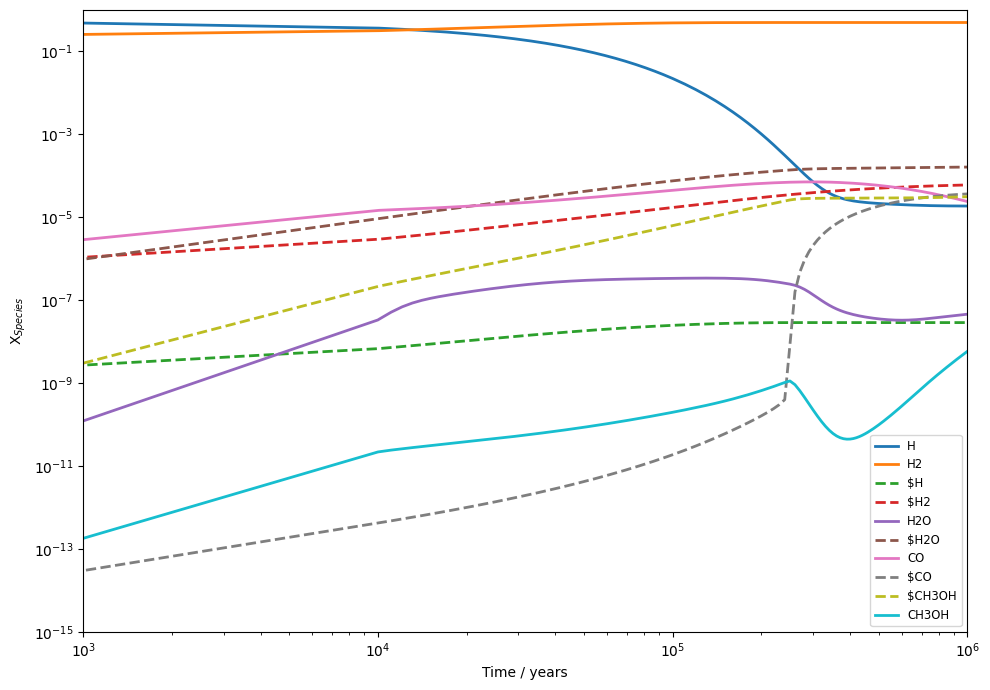

In [5]:
fig, ax = cloud.create_abundance_plot(species=["H", "H2", "$H", "$H2", "H2O", "$H2O", "CO", "$CO", "$CH3OH", "CH3OH"], figsize=(10, 7))
ax = ax.set(xscale="log", ylim=(1e-15, 1), xlim=(1e3, 1e6))

and that's it! You've run your first UCLCHEM model, checked that the element conservation is correct, and plotted the abundances.